In [360]:
from pathlib import Path
from medkit.core.text import TextDocument
from medkit.text.segmentation import SentenceTokenizer
from medkit.text.preprocessing import Normalizer, NormalizerRule
from medkit.text.ner import RegexpMatcher, RegexpMatcherRule , RegexpMatcherNormalization
from medkit.core.text import ModifiedSpan
from medkit.core.text import TextDocument, Entity, Span
from medkit.text.context import NegationDetector, NegationDetectorRule
from medkit.text.segmentation import SyntagmaTokenizer
from medkit.text.context import FamilyDetector
from unidecode import unidecode
import seaborn as sns
from medkit.core.text import Span, ModifiedSpan
from medkit.core.text import Entity
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import re
import pandas as pd
import random
pd.set_option('display.max_colwidth', None)

In [361]:
def statut_extraction_tabac(doc):
    statut = "UNKNOWN"
    n_oui = 0
    n_non = 0
    value_other_detected = False

    for ann in doc.anns:
        count = 0
        value_is_negated = False
        for attr in ann.attrs:
            if ann.label == "tabagisme":
                if attr.label == "other_detected":
                    value_other_detected = attr.value
                    if value_other_detected:
                        continue
                        
                if attr.label == "is_negated":
                    count+=1
                    if count ==1:
                        #print(f"text={ann.text!r}, spans={ann.spans}, label={ann.label},other_detected={value_other_detected} \n")
                        value_is_negated = attr.value
                        if value_is_negated:
                            n_non += 1
                        else:
                            n_oui += 1
                    

    if n_non > 0 and n_oui > 0:
        statut = "FUMEUR"
    elif n_non > 0:
        statut = "NON-FUMEUR"
    elif n_oui > 0:
        statut = "FUMEUR"
        
    #print(f"tabac:{statut}")

    return statut


In [362]:
def statut_extraction_alcool(doc):
    statut = "UNKNOWN"
    n_oui = 0
    n_non = 0
    value_other_detected = False

    for ann in doc.anns:
        count = 0
        value_is_negated = False
        for attr in ann.attrs:
            if ann.label == "alcool":
                if attr.label == "other_detected":
                    value_other_detected = attr.value
                    if value_other_detected:
                        continue
                        
                if attr.label == "is_negated":
                    count+=1
                    if count ==2:
                        #print(f"text={ann.text!r}, spans={ann.spans}, label={ann.label},is_negated={value_is_negated} \n")
                        value_is_negated = attr.value
                        if value_is_negated:
                            n_non += 1
                        else:
                            n_oui += 1
                    

    if n_non > 0 and n_oui > 0:
        statut = "ALCOOLIQUE"
    elif n_non > 0:
        statut = "NON-ALCOOLIQUE"
    elif n_oui > 0:
        statut = "ALCOOLIQUE"
        
    #print(f"alcool:{statut}")
    return statut


In [363]:
def statut_extraction_situation_familiale(doc):
    situation = "UNKNOWN"
    n_oui = 0
    n_non = 0
    value_other_detected = False

    for ann in doc.anns:
        count = 0
        value_is_negated = False
        for attr in ann.attrs:
            if ann.label == "situation":
                if attr.label == "other_detected":
                    value_other_detected = attr.value
                    if value_other_detected:
                        continue
                        
                if attr.label == "is_negated":
                    count+=1
                    if count ==3:
                        situation = ann.text.lower()
                        #print(f"text={ann.text!r}, spans={ann.spans}, label={ann.label},other_detected={value_other_detected} \n")
                        ## NORMALISATION: Seul, pas seul ou inconnu
                        if re.search(r"\bmarie[e]?\b", situation):
                            situation = "PAS SEUL"
                        elif re.search(r"\bcelibataire\b", situation):
                            situation = "SEUL"
                        elif re.search(r"\bdivorce[e]?\b", situation):
                            situation = "SEUL"
                        elif re.search(r"\bveuf\b", situation):
                            situation = "SEUL"
                        elif re.search(r"\bveuve\b", situation):
                            situation = "SEUL"
                        elif re.search(r"\bpacse[e][s]?\b", situation):
                            situation = "PAS SEUL"
                        elif re.search(r"\bconcubinage\b", situation):
                            situation = "PAS SEUL"
                        elif re.search(r"\b(vit|habite)\sseul(e)?\b", situation):
                            situation = "SEUL"
                        # Si il y a une négation
                        if value_is_negated == True:
                            # On inverse statut_marital
                            if situation == "SEUL":
                                situation = "PAS SEUL"
                            else:
                                situation = "SEUL"
    #print(f"situation:{situation}")
    return situation  

In [364]:
def clinical_case_recovery(output_folder,option_melange):
    # On récupère tous les fichiers texte dans le dossier
    txt_files = [f for f in os.listdir(output_folder) if f.endswith('.txt')]
    
    if option_melange == True:
        # On mélange les fichiers de manière aléatoire
        random.shuffle(txt_files)
    else:
        # On trie les fichiers par ordre alphabétique
        txt_files = sorted(txt_files)

    textes = {}  # dictionnaire de tous les cas cliniques

    # On ouvre et on extrait les textes dans textes
    for i in range(len(txt_files)):
        file_path = os.path.join(output_folder, txt_files[i])
        with open(file_path, 'r') as f:
            text = f.read()
        textes[txt_files[i]] = text
    return textes

## LES NEG DETECTOR

In [365]:
def neg_detector_tabac():

    ### QUELQUES REGEX NEGATION

    neg_rules = [       

    NegationDetectorRule(regexp=r"\bne\s*(semble|consomme|prend|fume)\s*pas"),
    NegationDetectorRule(regexp=r"jamais"),
    NegationDetectorRule(regexp=r"\bni\b"),
    NegationDetectorRule(regexp=r"\bnon\s+\b"),
    NegationDetectorRule(regexp=r"Tabac\s*[=:]?\s*0"),
    NegationDetectorRule(regexp=r"(pas|ni|ou)\s+de\s+(consommation\s+de\s+)?taba"),
    NegationDetectorRule(regexp=r"pas\s+d\'intoxication\s+tabagi"),
    NegationDetectorRule(regexp=r"0 tabac"),
    NegationDetectorRule(regexp=r"pas\s+d\'habitude"),


    ]
    
    neg_detector = NegationDetector(output_label="is_negated", rules=neg_rules)
    return neg_detector

In [366]:
def neg_detector_alcool():

    ### QUELQUES REGEX NEGATION

    neg_rules = [

        NegationDetectorRule(regexp=r"ne\s*boit\s*pas"),
        NegationDetectorRule(regexp=r"\bne/s*consomme/s*pas\b"),
        NegationDetectorRule(regexp=r"\bni\b"),
        NegationDetectorRule(regexp=r"\bpas\b"),
        NegationDetectorRule(regexp=r"\becarte\b"),
        NegationDetectorRule(regexp=r"\bnulle|negative\b"),
        NegationDetectorRule(regexp=r"rarement|occasion"),

    ]
    neg_detector = NegationDetector(output_label="is_negated", rules=neg_rules)
    return neg_detector

In [367]:
def neg_detector_situation_familiale():

### QUELQUES REGEX NEGATION

    neg_rules = [

        NegationDetectorRule(regexp=r"\bn'est pas\b"),
        NegationDetectorRule(regexp=r"\bne vit pas\b"),
        NegationDetectorRule(regexp=r"\bn'habite pas\b"),
        NegationDetectorRule(regexp=r"\bni\b"),
    ]
    neg_detector = NegationDetector(output_label="is_negated", rules=neg_rules)
    return neg_detector

## REGEX

In [368]:
regexp_rules_tabac = [
    RegexpMatcherRule(regexp=r"cigare(tte)?[s]?\b", label="tabagisme", exclusion_regexp ="en bout de cigare"),
    RegexpMatcherRule(regexp=r"\bfume\b", label="tabagisme", exclusion_regexp = "residu(s)?/s+de/s+fumee(s)?"),
    RegexpMatcherRule(regexp=r"taba(c|gisme|gique)[s]?", label="tabagisme"),
    RegexpMatcherRule(regexp=r"fumeur|fumeuse", label="tabagisme"),
    RegexpMatcherRule(regexp=r"fumait", label="tabagisme"),
    RegexpMatcherRule(regexp=r"nicotine", label="tabagisme"),
]
regexp_rules_alcool = [
    RegexpMatcherRule(regexp=r"alcool", label="alcool", exclusion_regexp = "acido/s*alcoolo|acido-alcoolo"), 
    RegexpMatcherRule(regexp=r"ethylisme|ethylique|ethylo", label="alcool"),
    RegexpMatcherRule(regexp=r"biere[s]?", label="alcool"),
    RegexpMatcherRule(regexp=r"champagne[s]?", label="alcool"),
    RegexpMatcherRule(regexp=r"\bvin[s]?\b", label="alcool"),
    RegexpMatcherRule(regexp=r"vodka[s]?", label="alcool"),

]

regexp_rules_familial = [
    RegexpMatcherRule(regexp=r"\bmarie[e]?\b", label="situation"),
    RegexpMatcherRule(regexp=r"celibataire", label="situation"),
    RegexpMatcherRule(regexp=r"divorce[e]?", label="situation"),
    RegexpMatcherRule(regexp=r"veuf", label="situation"),
    RegexpMatcherRule(regexp=r"\bveuve\b", label="situation"),
    RegexpMatcherRule(regexp=r"\bpacse[e][s]?\b", label="situation"),
    RegexpMatcherRule(regexp=r"\bconcubinage\b", label="situation"),
    RegexpMatcherRule(regexp=r"\b(vit|habite)\sseul(e)?\b", label="situation"),
]

## EXTRACTION STATUTS

In [369]:


def convert_to_pred_ents(docs):
    pred_ents = []
    
    for doc in docs:
        entities = []
        for entity in doc.anns:
            entity_spans = []
            start_list = []
            end_list = []
            
            for span in entity.spans:
                if isinstance(span, ModifiedSpan):
                    replaced_span = span.replaced_spans[0]
                    start_list.append(replaced_span.start)
                    end_list.append(replaced_span.start + span.length)
                elif isinstance(span, Span):
                    start_list.append(span.start)
                    end_list.append(span.end)
            
            if start_list:
                start = min(start_list)
            if end_list:
                end = max(end_list)
            
            entity_spans.append(Span(start=start, end=end))
            
            entity_obj = Entity(label=entity.label, spans=entity_spans, text=entity.text)
            entities.append(entity_obj)
        
        pred_ents.append(entities)
    
    return pred_ents

In [370]:
# Règles de normalisation du texte

norm_rules = [
    NormalizerRule(pattern_to_replace=r"é", new_text="e"),
    NormalizerRule(pattern_to_replace=r"è", new_text="e"),
    NormalizerRule(pattern_to_replace=r"ê", new_text="e"),
    NormalizerRule(pattern_to_replace=r"à", new_text="a"),
    NormalizerRule(pattern_to_replace=r"ç", new_text="c"),
    NormalizerRule(pattern_to_replace=r"ô", new_text="o"),
    NormalizerRule(pattern_to_replace=r"ù", new_text="u"),
    NormalizerRule(pattern_to_replace=r"œ", new_text="oe"),
    NormalizerRule(pattern_to_replace=r"°", new_text="deg"),
    NormalizerRule(pattern_to_replace=r"®", new_text="(r)"),
    NormalizerRule(pattern_to_replace=r"«", new_text="<<"),
    NormalizerRule(pattern_to_replace=r"»", new_text=">>"),
    NormalizerRule(pattern_to_replace=r"½", new_text="1/2"),
    NormalizerRule(pattern_to_replace=r"≥", new_text=">="),
    NormalizerRule(pattern_to_replace=r"æ", new_text="ae"),
    NormalizerRule(pattern_to_replace=r"…", new_text="..."),
    NormalizerRule(pattern_to_replace=r"≤", new_text="<="),
    NormalizerRule(pattern_to_replace=r"‰", new_text="test"),
    NormalizerRule(pattern_to_replace=r"ß", new_text="ss"),
    NormalizerRule(pattern_to_replace=r"±", new_text="+-"),
    NormalizerRule(pattern_to_replace=r"—", new_text="--"),
    NormalizerRule(pattern_to_replace=r"✔", new_text=""),
    NormalizerRule(pattern_to_replace=r"€", new_text="EUR"),
    NormalizerRule(pattern_to_replace=r"­", new_text="")
]

In [371]:
def extraction_finale(clinical_case_repo,option_melange):
    # Listes pour stocker les données
    data_tabac = []
    data_alcool = []
    data_situation = []
    data = []
    docs = []
    # On charge les cas cliniques dans un dico {nom fichier: cas clinique}
    clinical_cases_dico = clinical_case_recovery(clinical_case_repo,option_melange)
    for fichier, clinical_case in clinical_cases_dico.items():

        
        doc = TextDocument(text=clinical_case)
        # On normalise le texte 
        normalizer = Normalizer(output_label="clean_text", rules=norm_rules)
        clean_segment = normalizer.run([doc.raw_segment])[0]
        
        ## On sépare le texte en phrases
        sent_tokenizer = SentenceTokenizer(
            output_label="sentence",
            punct_chars=[".", "?", "!"],
        )
        sentences = sent_tokenizer.run([clean_segment])

        ## On sépare les phrases en syntagmas
        synt_tokenizer = SyntagmaTokenizer(
            output_label="sentence",
            separators=[r"\bmais\b", r"\bet\b"],
        )
        syntagmas = synt_tokenizer.run(sentences)

        # Création de l'objet neg detector
        neg_detector_tabac_obj = neg_detector_tabac()
        neg_detector_alcool_obj = neg_detector_alcool()
        neg_detector_statut_familial_obj = neg_detector_situation_familiale()

        # On applique neg detector aux syntagmas
        neg_detector_tabac_obj.run(syntagmas)
        neg_detector_alcool_obj.run(syntagmas)
        neg_detector_statut_familial_obj.run(syntagmas)

        # On applique family detector aux syntagmas
        family_detector = FamilyDetector(output_label='other_detected')
        family_detector.run(syntagmas)

        # CREATION OF ENTITIES
        regexp_matcher_tabac = RegexpMatcher(rules=regexp_rules_tabac, attrs_to_copy=["is_negated", "other_detected"])
        regexp_matcher_alcool = RegexpMatcher(rules=regexp_rules_alcool, attrs_to_copy=["is_negated", "other_detected"])
        regexp_matcher_familial = RegexpMatcher(rules=regexp_rules_familial, attrs_to_copy=["is_negated", "other_detected"])
        
        
        entities_tabac = regexp_matcher_tabac.run(syntagmas)
        entities_alcool = regexp_matcher_alcool.run(syntagmas)
        entities_familial = regexp_matcher_familial.run(syntagmas)

        for entity in entities_tabac:
            doc.anns.add(entity)

        for entity in entities_alcool:
            doc.anns.add(entity)

        for entity in entities_familial:
            if entity.label == "situation":
                situation = entity.text.lower()
                #Ce qui nous interesse est le terme "marié" qui peut aussi etre un prenom
                if re.search(r"\bmarie[e]?\b", situation):
                    #Si la taille des spans>1 c'est qu'il y'a eu une modif du a un accent donc on ajoute l'annot
                    if len(entity.spans)>1:
                        doc.anns.add((entity))
                #On ajoute toutes les autres annotations car elles ne sont pas ambigue
                else:
                    doc.anns.add((entity))

        docs.append(doc)
               
        tabagisme = statut_extraction_tabac(doc)
        alcool = statut_extraction_alcool(doc)
        situation = statut_extraction_situation_familiale(doc)

        # Remplissage de data
        data_tabac.append([fichier, clinical_case, tabagisme])
        data_alcool.append([fichier, clinical_case, alcool])
        data_situation.append([fichier, clinical_case, situation])
        data.append([fichier, clinical_case, tabagisme,alcool,situation])

    df_tabac = pd.DataFrame(data_tabac, columns=["nom fichier", "cas clinique", "tabagisme"])
    df_alcool = pd.DataFrame(data_alcool, columns=["nom fichier", "cas clinique", "alcool"])
    df_situation = pd.DataFrame(data_situation, columns=["nom fichier", "cas clinique", "situation"])
    df = pd.DataFrame(data, columns=["nom fichier", "cas clinique", "tabagisme", "alcool", "situation"])
    
    return df,docs

## PREPARATION ANNOTATION TABAC

## On fait tourner le code sur ces fichiers uniquement

In [372]:
df,docs_medkit = extraction_finale("51_fichiers_annotation_tabac",option_melange=False)
print("fin")

fin


In [373]:
df['tabagisme'].value_counts()

tabagisme
FUMEUR        19
UNKNOWN       17
NON-FUMEUR    15
Name: count, dtype: int64

In [374]:
df.shape

(51, 5)

## EVALUATION: COMPARAISON ENTRE ANNOTATION BRAT ET MEDKIT

In [375]:
# On récupère les annotations brat

from medkit.io.brat import BratInputConverter

# Define Input Converter 
brat_converter = BratInputConverter()

path= "/home/mhassani/Documents/Stage/env/brat-master/data/51_fichiers_annotation_tabac"

# Load brat into a list of documents
docs_brat = brat_converter.load(dir_path = path)
len(docs_brat)

51

In [376]:
pred_ents = convert_to_pred_ents(docs_medkit)

In [377]:
from medkit.core.text import TextDocument, Entity, Span
from medkit.text.metrics.ner import SeqEvalEvaluator

# define a evaluator using `iob2` as tagging scheme
evaluator = SeqEvalEvaluator(tagging_scheme="iob2")
metrics = evaluator.compute(documents=docs_brat, predicted_entities=pred_ents)

In [378]:
for metric, value in metrics.items():
    print(f"{metric}: {value}")

overall_precision: 1.0
overall_recall: 1.0
overall_f1-score: 1.0
overall_support: 63
overall_acc: 1.0
alcool_precision: 1.0
alcool_recall: 1.0
alcool_f1-score: 1.0
alcool_support: 25
situation_precision: 1.0
situation_recall: 1.0
situation_f1-score: 1.0
situation_support: 1
tabagisme_precision: 1.0
tabagisme_recall: 1.0
tabagisme_f1-score: 1.0
tabagisme_support: 37


## Evaluation des attributs is_negated

In [379]:
def generate_entity_vectors(docs_medkit,docs_brat):
    count = 0
    vecteur_gold = []
    vecteur_predicted = []
    for gold_doc, predicted_doc in zip(docs_brat, docs_medkit):
        gold_entities = gold_doc.anns
        predicted_entities = predicted_doc.anns
        count += 1

        for gold_entity in zip(gold_entities):
            if not gold_entity[0].attrs:
                vecteur_gold.append([False,gold_entity[0].text,gold_entity[0].spans,count])
            else:
                vecteur_gold.append([True,gold_entity[0].text,gold_entity[0].spans,count])


        for predicted_entity in zip(predicted_entities):
            rule_negation=0
            # Si il y a eu une modification du au prétraitement du texte
            if len(predicted_entity[0].spans)>1:
                ## On vérifie l'ordre des spans
                if isinstance(predicted_entity[0].spans[0], Span):
                    predicted_spans = predicted_entity[0].spans[0]
                if isinstance(predicted_entity[0].spans[1], Span):
                    predicted_spans = predicted_entity[0].spans[1]
            else: 
                predicted_spans = predicted_entity[0].spans

            for predicted_attr in predicted_entity[0].attrs:
                rule_negation+=1
                if rule_negation == 1: 
                    if predicted_entity[0].label == "tabagisme":
                        vecteur_predicted.append([predicted_attr.value,predicted_entity[0].text,predicted_spans,count])
                if rule_negation == 2: 
                    if predicted_entity[0].label == "alcool":
                        vecteur_predicted.append([predicted_attr.value,predicted_entity[0].text,predicted_spans,count])
                if rule_negation == 3: 
                    if predicted_entity[0].label == "situation":
                        vecteur_predicted.append([predicted_attr.value,predicted_entity[0].text,predicted_spans,count])
    return(vecteur_predicted,vecteur_gold)

In [380]:
vecteur_predicted,vecteur_gold=generate_entity_vectors(docs_medkit,docs_brat)

In [381]:
## On vérifie si listes sont comparables
for i in range (len(vecteur_predicted)):
    correspondance_ordre=True
    if vecteur_predicted[i][3:4] != vecteur_gold[i][3:4]:
        correspondance_ordre == False
    if not correspondance_ordre:
        print("L'ordre des listes ne correspond pas.")

In [382]:
## On crée nos liste avec des 0 et 1 
# 0 = False et  = True

def modifier_liste(liste):
    nouvelle_liste = []
    for item in liste:
        premier_terme = item[0]
        if premier_terme:
            nouvelle_liste.append(premier_terme)
        else:
            nouvelle_liste.append(premier_terme)
    return nouvelle_liste

In [383]:
predicted_neg_list = modifier_liste(vecteur_predicted)
gold_neg_list = modifier_liste(vecteur_gold)

In [384]:
print(gold_neg_list)
print(predicted_neg_list)

[True, True, True, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, True, False, True, True, False, False, False, False, False, True, True, True, False, True, True, True, True, True, False, False, True, False, True, False, False, True, False, False, False, True, False]
[True, True, True, True, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, True, False, True, True, False, False, True, False, False, True, True, True, False, True, True, True, True, True, True, False, True, True, True, False, False, True, False, False, False, True, False]


### Evaluation avec sklearn

In [385]:
from sklearn.metrics import top_k_accuracy_score

y_true = gold_neg_list
y_pred = predicted_neg_list

k = 1  # Top-1 précision
accuracy = top_k_accuracy_score(y_true, y_pred, k=k)

print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.94


In [386]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict=True)

for metric, value in report_dict.items():
    if isinstance(value, dict):
        print(f"{metric}")
        for key,val in value.items():
            print(f"   {key}: {val}")
    else:
        print(f"{metric}: {value}")

False
   precision: 1.0
   recall: 0.9
   f1-score: 0.9473684210526316
   support: 40
True
   precision: 0.8518518518518519
   recall: 1.0
   f1-score: 0.92
   support: 23
accuracy: 0.9365079365079365
macro avg
   precision: 0.9259259259259259
   recall: 0.95
   f1-score: 0.9336842105263159
   support: 63
weighted avg
   precision: 0.9459141681363904
   recall: 0.9365079365079365
   f1-score: 0.9373767752715122
   support: 63


In [387]:
n_erreur=0
for i in range(len(vecteur_predicted)):
    if vecteur_predicted[i][0:1] != vecteur_gold[i][0:1]:
        n_erreur+=1
        print(vecteur_gold[i][0:1])
        print(vecteur_gold[i][3:4])
        print(vecteur_predicted[i][0:1])
        print(vecteur_predicted[i][3:4])
        print("\n")
print(1-n_erreur/len(vecteur_gold))

[False]
[20]
[True]
[20]


[False]
[30]
[True]
[30]


[False]
[36]
[True]
[36]


[False]
[43]
[True]
[43]


0.9365079365079365


## Evaluation des statuts

In [23]:
# Exporter le DataFrame en tant que fichier CSV
#df.to_csv('tabac_df.csv', index=False)

In [388]:
df_final = pd.read_csv('tabac_df.csv')

In [392]:
df_final.fillna("UNKNOWN", inplace=True)
df_final.replace({"NON-FUMEUR": "NON", "NON-ALCOOLIQUE": "NON", "FUMEUR": "OUI",
                  "ALCOOLIQUE": "OUI"}, inplace=True)

In [396]:
# Supposons que vous ayez un DataFrame nommé df_final contenant les colonnes "tabagisme" et "tabagisme_V"

# Comparer les colonnes "tabagisme" et "tabagisme_V"
df_erreurs = df_final[df_final['tabagisme'] != df_final['tabagisme_V']]

# Afficher les lignes où il y a des erreurs
df_erreurs

,nom fichier,cas clinique,tabagisme,alcool,situation,tabagisme_V,alcool_V,situation_V
19,filepdf-28-cas.txt,"M. âgé de 74 ans a été hospitalisé pour des douleurs lombaires gauches en septembre 1999. On notait dans les antécédents chirurgicaux : une appendicectomie et une exploration thoracique pour plaie par balle en 1945. Au plan médical, il existait une ichtyose cutanée congénitale, une hypertension artérielle non traitée, une intoxication tabagique à plus de 100 paquets/années et une probable intoxication éthylique.\n\nL’interrogatoire retrouvait la notion de coliques néphrétiques gauches fréquentes, évoluant depuis au moins 30 ans, mais jamais explorées. Il existait une altération de l’état général majeure avec cachexie. Le patient était apyrétique. L’examen retrouvait à la palpation une masse lombaire gauche douloureuse. Au plan biologique, il existait un syndrome inflammatoire net : CRP supérieure à 200 ng/ml, VS = 117 mm à la première heure, avec une anémie à 9 g d’hémoglobine par dl mais sans hyperleucocytose (leucocytes = 8000). On notait une cholestase modérée sans cytolyse. La fonction rénale était conservée (créatininémie : 82 µmol/l). La calcémie était normale. Les urines étaient stériles. L’échographie rénale montrait un rein gauche dédifférencié, hétérogène, augmenté de volume, avec présence de multiples calculs.\nLes cavités pyélocalicielles n’étaient pas individualisables. La radiographie d’abdomen sans préparation confirmait la présence de calcifications de grande taille évoquant un calcul coralliforme à gauche (Figure 1). Un examen tomodensitométrique abdominal confirmait la présence d’un rein gauche détruit autour de multiples et volumineux calculs pyéliques et caliciels. Les limites du rein gauche vers le bas et en arrière étaient floues avec un aspect d’infiltration du psoas (Figure 2). Il n’existait pas d’adénopathies visibles. Le rein droit, le foie étaient normaux. Une artériographie rénale a été réalisée qui montrait que le rein gauche était vascularisé par une artère unique, filiforme, sans processus hypervasculaire qui aurait évoqué une étiologie tumorale et qui aurait pu être embolisée (Figure 3). La radio de thorax était normale et la tomodensitométrie cérébrale objectivait des séquelles ischémiques frontales droites, sans métastases. Malgré le risque vital inhérent à la cachexie, il a été décidé de réaliser une néphrectomie de propreté en retenant le diagnostic préopératoire de pyonéphrose. L’intervention a été précédée d’une urétéro-pyélographie rétrograde gauche qui a montré un uretère fin avec opacification de cavités pyélocalicielles déformées contenant des calculs.\n\nLa néphrectomie réalisée par voie lombaire gauche a concerné un rein inflammatoire et détruit autour de volumineux calculs pyéliques et caliciels. Il existait une infiltration importante du psoas en arrière évoquant macroscopiquement un envahissement tumoral tout autant qu’une extension de réactions inflammatoires intenses.\nL’examen anatomo-pathologique a affirmé la présence d’un volumineux carcinome épidermoïde différencié mature (Figure 4) développé au dépens des cavités excrétrices, pyéliques et calicielles, envahissant la graisse périrénale et ayant détruit la totalité du parenchyme rénal. L’analyse des calculs a retrouvé une lithiase majoritaire en phosphate calcique avec un tiers de carbapatite évoquant, malgré l’absence de struvite, un processus par infection à germe uréasique. Les suites précoces ont été simples au plan local. Le patient a repris une alimentation au 2ème jour. Il a quitté le service d’Urologie pour un service de moyen séjour au 15ème jour. Cependant, l’état général a continué à se dégrader et le décès est survenu 1 mois après l’intervention.\n",NON,OUI,UNKNOWN,OUI,OUI,UNKNOWN
42,filepdf-840-1-cas.txt,"Mr M.Y est âgé de 48 ans, tabagique chronique non sevré, sans autres facteurs de risque cardiovasculaire, il avait consulté aux urgences pour une douleur pelvienne droite croissante évolutive depuis quelq

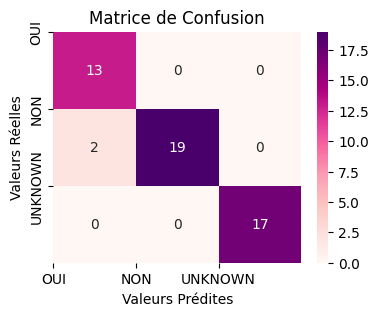

In [394]:
# Calcul de la matrice de confusion
cm = confusion_matrix(df_final['tabagisme_V'], df_final['tabagisme'])

# Création d'une figure avec Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='RdPu', fmt='g')

# Définition des labels et du titre
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')

# Définition des étiquettes des axes x et y avec un alignement au centre
tick_labels = ['OUI', 'NON', 'UNKNOWN']
plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels)
plt.yticks(ticks=range(len(tick_labels)), labels=tick_labels)


# Affichage de la figure
plt.show()


In [410]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

y_true = df_final['tabagisme_V'].values
y_pred = df_final['tabagisme'].values

In [409]:
# Calculez les métriques
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Affichez les résultats

print("Précision globale (Accuracy):", round(accuracy,2))
print("Classification Report:")
print(report)

Précision globale (Accuracy): 0.96
Classification Report:
              precision    recall  f1-score   support

         NON       0.87      1.00      0.93        13
         OUI       1.00      0.90      0.95        21
     UNKNOWN       1.00      1.00      1.00        17

    accuracy                           0.96        51
   macro avg       0.96      0.97      0.96        51
weighted avg       0.97      0.96      0.96        51



## PREPARATION ANNOTATION ALCOOL

In [411]:
df,docs_medkit = extraction_finale("51_fichiers_annotation_alcool",option_melange=False)
print("fin")

fin


In [412]:
df["alcool"].value_counts()

alcool
ALCOOLIQUE        20
UNKNOWN           16
NON-ALCOOLIQUE    15
Name: count, dtype: int64

In [413]:
df

nom fichier   
0      filehtml-23-cas.txt  \
1      filehtml-24-cas.txt   
2      filehtml-29-cas.txt   
3      filepdf-101-cas.txt   
4    filepdf-103-1-cas.txt   
5      filepdf-109-cas.txt   
6      filepdf-160-cas.txt   
7      filepdf-163-cas.txt   
8      filepdf-194-cas.txt   
9      filepdf-243-cas.txt   
10     filepdf-254-cas.txt   
11      filepdf-28-cas.txt   
12     filepdf-387-cas.txt   
13     filepdf-389-cas.txt   
14   filepdf-393-2-cas.txt   
15     filepdf-395-cas.txt   
16     filepdf-412-cas.txt   
17     filepdf-447-cas.txt   
18     filepdf-474-cas.txt   
19   filepdf-481-5-cas.txt   
20   filepdf-492-2-cas.txt   
21   filepdf-496-2-cas.txt   
22     filepdf-500-cas.txt   
23     filepdf-503-cas.txt   
24   filepdf-508-3-cas.txt   
25     filepdf-513-cas.txt   
26     filepdf-527-cas.txt   
27   filepdf-533-5-cas.txt   
28  filepdf-534-10-cas.txt   
29  filepdf-534-11-cas.txt   
30  filepdf-534-12-cas.txt   
31  filepdf-534-17-cas.txt   
32     filepdf-549-cas.txt   
33   filepdf-630-5-cas.txt   
34   filepdf-630-6-cas.txt   
35   filepdf-630-7-cas.txt   
36   filepdf-630-8-cas.txt   
37     filepdf-680-cas.txt   
38      filepdf-69-cas.txt   
39     filepdf-700-cas.txt   
40     filepdf-710-cas.txt   
41     filepdf-750-cas.txt   
42     filepdf-756-cas.txt   
43     filepdf-757-cas.txt   
44   filepdf-776-7-cas.txt   
45     filepdf-803-cas.txt   
46     filepdf-829-cas.txt   
47     filepdf-856-cas.txt   
48   filepdf-872-2-cas.txt   
49      filepdf-88-cas.txt   
50    filepdf-91-1-cas.txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## EVALUATION: COMPARAISON ENTRE ANNOTATION BRAT ET MEDKIT

In [414]:
# On récupère les annotations brat

from medkit.io.brat import BratInputConverter

# Define Input Converter 
brat_converter = BratInputConverter()

path= "/home/mhassani/Documents/Stage/env/brat-master/data/51_fichiers_annotation_alcool"

# Load brat into a list of documents
docs_brat = brat_converter.load(dir_path = path)
len(docs_brat)

51

In [415]:
len(docs_brat)

51

In [416]:
pred_ents = convert_to_pred_ents(docs_medkit)
pred = convert_to_pred_ents(docs_brat)

In [417]:
from medkit.core.text import TextDocument, Entity, Span
from medkit.text.metrics.ner import SeqEvalEvaluator

# define a evaluator using `iob2` as tagging scheme
evaluator = SeqEvalEvaluator(tagging_scheme="iob2")
metrics = evaluator.compute(documents=docs_brat, predicted_entities=pred_ents)

In [418]:
for metric, value in metrics.items():
    print(f"{metric}: {value}")

overall_precision: 1.0
overall_recall: 1.0
overall_f1-score: 1.0
overall_support: 81
overall_acc: 1.0
alcool_precision: 1.0
alcool_recall: 1.0
alcool_f1-score: 1.0
alcool_support: 63
situation_precision: 1.0
situation_recall: 1.0
situation_f1-score: 1.0
situation_support: 1
tabagisme_precision: 1.0
tabagisme_recall: 1.0
tabagisme_f1-score: 1.0
tabagisme_support: 17


## Evaluation des attributs is_negated

In [419]:
vecteur_predicted,vecteur_gold=generate_entity_vectors(docs_medkit,docs_brat)
## On vérifie si listes sont comparables
for i in range (len(vecteur_predicted)):
    correspondance_ordre=True
    if vecteur_predicted[i][3:4] != vecteur_gold[i][3:4]:
        correspondance_ordre == False
    if not correspondance_ordre:
        print("L'ordre des listes ne correspond pas.")

In [420]:
predicted_neg_list = modifier_liste(vecteur_predicted)
gold_neg_list = modifier_liste(vecteur_gold)

### Evaluation avec sklearn

In [421]:
from sklearn.metrics import top_k_accuracy_score

y_true = gold_neg_list
y_pred = predicted_neg_list

k = 1  # Top-1 précision
accuracy = top_k_accuracy_score(y_true, y_pred, k=k)

print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.86


In [422]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict=True)

for metric, value in report_dict.items():
    if isinstance(value, dict):
        print(f"{metric}")
        for key,val in value.items():
            print(f"   {key}: {val}")
    else:
        print(f"{metric}: {value}")

False
   precision: 0.9361702127659575
   recall: 0.8461538461538461
   f1-score: 0.8888888888888888
   support: 52
True
   precision: 0.7647058823529411
   recall: 0.896551724137931
   f1-score: 0.8253968253968255
   support: 29
accuracy: 0.8641975308641975
macro avg
   precision: 0.8504380475594493
   recall: 0.8713527851458887
   f1-score: 0.8571428571428572
   support: 81
weighted avg
   precision: 0.874781748790927
   recall: 0.8641975308641975
   f1-score: 0.8661571624534586
   support: 81


In [423]:
n_erreur=0
for i in range(len(vecteur_predicted)):
    if vecteur_predicted[i][0:1] != vecteur_gold[i][0:1]:
        n_erreur+=1
        print(vecteur_gold[i][0:1])
        print(vecteur_gold[i][3:4])
        print(vecteur_predicted[i][0:1])
        print(vecteur_predicted[i][3:4])
        print("\n")
print(1-n_erreur/len(vecteur_gold))

[False]
[12]
[True]
[12]


[False]
[25]
[True]
[25]


[False]
[25]
[True]
[25]


[True]
[33]
[False]
[33]


[True]
[33]
[False]
[33]


[False]
[33]
[True]
[33]


[False]
[33]
[True]
[33]


[True]
[34]
[False]
[34]


[False]
[37]
[True]
[37]


[False]
[39]
[True]
[39]


[False]
[44]
[True]
[44]


0.8641975308641976


## Evaluation du statut alcoolique

In [424]:
# Exporter le DataFrame en tant que fichier CSV
#df.to_csv('alcool_df.csv', index=False)

In [425]:
df_final = pd.read_csv('alcool_df.csv')

In [426]:
df_final.fillna("UNKNOWN", inplace=True)
df_final.replace({"NON-FUMEUR": "NON", "NON-ALCOOLIQUE": "NON", "FUMEUR": "OUI",
                  "ALCOOLIQUE": "OUI"}, inplace=True)

In [427]:
# Supposons que vous ayez un DataFrame nommé df_final contenant les colonnes "tabagisme" et "tabagisme_V"

# Comparer les colonnes "tabagisme" et "tabagisme_V"
df_erreurs = df_final[df_final['alcool'] != df_final['alcool_V']]

# Afficher les lignes où il y a des erreurs
df_erreurs

,nom fichier,cas clinique,tabagisme,alcool,situation,tabagisme_V,alcool_V,situation_V
24,filepdf-508-3-cas.txt,"Un homme d'âge non communiqué était retrouvé mort dans sa cellule de Maison d'Arrêt. La congestion polyviscérale retrouvée par le médecin légiste lors de l'autopsie orientait le décès sur une cause toxique. L'enquête n'a pas su déterminer s'il s'agissait d'un suicide ou d'un accident. La recherche de toxiques notamment végétaux réalisée un an après une première expertise où seule la présence d'alcool éthylique à 0,93 g/L avait été mise en évidence, montrait l'ingestion d'atropine suivie d'un processus mortel très rapide puisque son absence de l'urine montrait que l'élimination n'avait pas commencé (tableau VII). La concentration plus faible dans le contenu gastrique que dans le sang indiquait que la résorption était sur la phase finale. Le décès pouvait ainsi être estimé entre une demi-heure et deux heures après la prise. Son origine est très vraisemblablement due à l'ingestion d'ampoules d'atropine (réservées à l'usage hospitalier en anesthésie-réanimation) déclarées volées à l'infirmerie de la Maison d'Arrêt.\n",UNKNOWN,NON,UNKNOWN,UNKNOWN,OUI,UNKNOWN
33,filepdf-630-5-cas.txt,"Homme de 28 ans travaillant dans un bar à kava et impliqué dans une rixe à son domicile. Sa chaîne stéréo étant réglée trop fort, son voisinage se plaint. Il s'en suit une altercation verbale qui dégénère ; sous les coups le sujet s'écroule puis décède. Un prélèvement sanguin intracardiaque est réalisé. L'alcoolémie (par CPG/FID) est négative, la recherche de dérivés cannabinoïdes par immunoenzymologie est positive (45 ng/ml) ; le screening toxicologique par CLHP/BD révèle des pics et spectres caractéristiques des kavalactones. Les deux agresseurs n'avaient qu'une alcoolémie de 0,40 et 0,61 g/L.\n",UNKNOWN,OUI,UNKNOWN,UNKNOWN,NON,UNKNOWN
36,filepdf-630-8-cas.txt,"Femme de 30 ans ayant porté plainte pour viol. Des prélèvements divers sur la victime (pour sérologies, test de grossesse, recherche de toxiques sanguins, écouvillonnages...) sont effectués aux Urgences de l'Hôpital sur réquisition de la Police Nationale. L'alcoolémie est positive (1,31 g/L), la recherche des dérivés cannabinoïdes plasmatiques est négative (Cannabis One-Step ELISA, International Diagnostic) le screening toxicologique plasmatique par CLHP/BD révèle des pics et spectres caractéristiques des kavalactones (Figure 11). L'enquête déterminera par la suite que la jeune femme désirait se venger de son ami qui l'avait abandonnée sur un îlot, au large de Nouméa. Il s'agissait donc d'une dénonciation calomnieuse.\n",UNKNOWN,NON,UNKNOWN,UNKNOWN,OUI,UNKNOWN


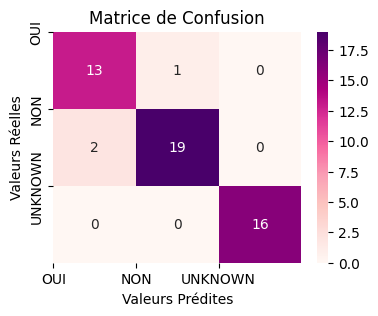

In [428]:
# Calcul de la matrice de confusion
cm = confusion_matrix(df_final['alcool_V'], df_final['alcool'])

# Création d'une figure avec Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='RdPu', fmt='g')

# Définition des labels et du titre
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')

# Définition des étiquettes des axes x et y avec un alignement au centre
tick_labels = ['OUI', 'NON', 'UNKNOWN']
plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels)
plt.yticks(ticks=range(len(tick_labels)), labels=tick_labels)


# Affichage de la figure
plt.show()


In [431]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

y_true = df_final['alcool_V'].values
y_pred = df_final['alcool'].values

In [432]:
# Calculez les métriques
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Affichez les résultats

print("Précision globale (Accuracy):", round(accuracy,2))
print("Classification Report:")
print(report)

Précision globale (Accuracy): 0.94
Classification Report:
              precision    recall  f1-score   support

         NON       0.87      0.93      0.90        14
         OUI       0.95      0.90      0.93        21
     UNKNOWN       1.00      1.00      1.00        16

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51



## PREPARATION ANNOTATION SITUATION FAMILIALE

## On fait tourner le code sur ces fichiers uniquement 

In [433]:
df,docs_medkit = extraction_finale("51_fichiers_annotation_situation",option_melange=False)
print("fin")

fin


In [434]:
df["situation"].value_counts()

situation
UNKNOWN     32
SEUL        10
PAS SEUL     9
Name: count, dtype: int64

In [435]:
df

,nom fichier,cas clinique,tabagisme,alcool,situation
0,filepdf-108-cas.txt,"Le patient, âgé de 48 ans, a été admis pour une douleur lombaire droite présente depuis 12 heures et d’apparition spontanée. La douleur n’a pas cédé aux antalgiques, ni aux anti-spasmodiques. Il n’y a aucune notion de traumatisme. A l’examen physique, il existait une sensibilité au niveau du point costo-musculaire droit. La tension artérielle était de 180/120 mm Hg et la fréquence cardiaque à 100/mn. Le reste de l’examen somatique était normal.\n\nL’hémoglobine est de 12.1 g/dl et l’hématocrite de 30 %. La fonction rénale était normale. L’examen cytobactériologique des urines mettait en évidence une hématurie microscopique.\n\nLa radiographie de l’abdomen montre un élargissement de l’ombre rénale droite et l’échographie ne permet pas de visualiser précisément les contours du rein. La tomodensitométrie abdominale montrait l’image d’une hémorragie péri-rénale et la présence d’une masse au niveau du pôle supérieur droit, ne captant pas le produit de contraste (Figure 1). L’artériographie sélective montrait une zone hypo-vascularisée au sommet supérieur du rein, mais l’embolisation a été infructueuse (Figure 2). Le diagnostic d’hémorragie péri-rénale spontanée était retenu chez ce patient, mais l’origine futt à déterminer. Après 24 heures de surveillance, le taux d’hémoglobine était tombé à 7,6 g/dl et l’hématocrite à 22%. Nous décidions de réaliser une néphrectomie radicale par voie thoraco-lombaire. Celle-ci a permis de drainer plus de deux litres de sang. Les suites postopératoires furent simples.\n\nL’examen anatomo-pathologique de la pièce opératoire a montré la présence d’une formation blanchâtre d’environ 2 cm de diamètre au niveau du pôle supérieur du rein. L’examen microscopique montrait une prolifération de cellules à disposition papillaire, faites d’axes conjonctifs grêles (Figure 3). Les cellules y possèdaient un cytoplasme éosinophile assez abondant et leur activité mitotique était nulle. Cette tumeur correspondait à un adénome papillaire.\n\nL’évolution post-opératoires a été favorable avec un recul de 15 mois. Le patient se porte bien avec une fonction rénale normale et une tension artérielle équilibrée.\n",UNKNOWN,UNKNOWN,UNKNOWN
1,filepdf-112-cas.txt,"Mr. H. M… âgé de 45 ans, ouvrier, ayant des antécédents de chancre syphilitique, était admis dans le service pour un syndrome obstructif du bas appareil urinaire. L’histoire de la maladie remontait à 10 ans par l’installation progressive d’une dysurie, pollakiurie (2 à 3 fois/nuit) et d’une incontinence urinaire par regorgement. Sa symptomatologie s’était aggravée par l’apparition d’une boiterie et d’une déformation indolore du genou droit .\n\nL’examen clinique révélait une déformation et une augmentation du volume du genou droit, un globe vésical et une fuite d’urine à la palpation de la région hypogastrique. Le toucher rectal montrait une prostate indurée dans sa totalité et de petit volume. L’examen neurologique montrait l’absence de déficit moteur, une hypotonie et une dépression des réflexes ostéo-tendineux aux membres inférieurs, une hypo-esthésie du gland et un réflexe photo-moteur diminué des deux côtés avec un myosis serré à gauche (signe d’Argyll-Robertson). L’ensemble constitue le syndrome cordonal postérieur.\n\nLa fonction rénale était normale et l’ECBU était stérile. La sérologie syphilitique était fortement positive et la ponction lombaire avait révélé une méningite lymphocytaire. L’échographie rénale était normale\n\nL’urétrocystographie rétrograde et mictionnelle avait montré une vessie de grande capacité avec un important résidu post mictionnel (d’environ 500 ml) (Figure 1). La cystomanométrie et le profil uretral objectivaient une vessie hypo-active avec une capacité vésicale de 1200 ml et une pression uretrale normale. Le débit maximum était de 10 ml/ seconde. La radiographie du genou droit montrait une destruction articulaire avec luxation de l’articulation fémoro-tibial

## EVALUATION: COMPARAISON ENTRE ANNOTATION BRAT ET MEDKIT

In [436]:
# On récupère les annotations brat

from medkit.io.brat import BratInputConverter

# Define Input Converter 
brat_converter = BratInputConverter()

path= "/home/mhassani/Documents/Stage/env/brat-master/data/51_fichiers_annotation_situation"

# Load brat into a list of documents
docs_brat = brat_converter.load(dir_path = path)
len(docs_brat)

51

In [437]:
pred_ents = convert_to_pred_ents(docs_medkit)

In [438]:
from medkit.core.text import TextDocument, Entity, Span
from medkit.text.metrics.ner import SeqEvalEvaluator

# define a evaluator using `iob2` as tagging scheme
evaluator = SeqEvalEvaluator(tagging_scheme="iob2")
metrics = evaluator.compute(documents=docs_brat, predicted_entities=pred_ents)

In [439]:
for metric, value in metrics.items():
    print(f"{metric}: {value}")

overall_precision: 0.9777777777777777
overall_recall: 0.9777777777777777
overall_f1-score: 0.9777777777777777
overall_support: 45
overall_acc: 0.9999106760040017
alcool_precision: 0.9473684210526315
alcool_recall: 1.0
alcool_f1-score: 0.972972972972973
alcool_support: 18
situation_precision: 1.0
situation_recall: 0.9523809523809523
situation_f1-score: 0.975609756097561
situation_support: 21
tabagisme_precision: 1.0
tabagisme_recall: 1.0
tabagisme_f1-score: 1.0
tabagisme_support: 6


### Evaluation des attributs is_negated

In [440]:
vecteur_predicted,vecteur_gold=generate_entity_vectors(docs_medkit,docs_brat)

In [441]:
predicted_neg_list = modifier_liste(vecteur_predicted)
gold_neg_list = modifier_liste(vecteur_gold)

### Evaluation avec sklearn

In [442]:
from sklearn.metrics import top_k_accuracy_score

y_true = gold_neg_list
y_pred = predicted_neg_list

k = 1  # Top-1 précision
accuracy = top_k_accuracy_score(y_true, y_pred, k=k)

print("Accuracy: {:.2f}".format(accuracy))

Accuracy: 0.82


In [443]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_true, y_pred, output_dict=True)

for metric, value in report_dict.items():
    if isinstance(value, dict):
        print(f"{metric}")
        for key,val in value.items():
            print(f"   {key}: {val}")
    else:
        print(f"{metric}: {value}")

False
   precision: 0.9
   recall: 0.9
   f1-score: 0.9
   support: 40
True
   precision: 0.2
   recall: 0.2
   f1-score: 0.20000000000000004
   support: 5
accuracy: 0.8222222222222222
macro avg
   precision: 0.55
   recall: 0.55
   f1-score: 0.55
   support: 45
weighted avg
   precision: 0.8222222222222222
   recall: 0.8222222222222222
   f1-score: 0.8222222222222222
   support: 45


In [444]:
n_erreur=0
for i in range(len(vecteur_predicted)):
    if vecteur_predicted[i][0:1] != vecteur_gold[i][0:1]:
        n_erreur+=1
        print(vecteur_gold[i][0:1])
        print(vecteur_gold[i][3:4])
        print(vecteur_predicted[i][0:1])
        print(vecteur_predicted[i][3:4])
        print("\n")
print(1-n_erreur/len(vecteur_gold))

[True]
[26]
[False]
[26]


[True]
[26]
[False]
[26]


[False]
[26]
[True]
[26]


[False]
[26]
[True]
[26]


[False]
[31]
[True]
[31]


[True]
[37]
[False]
[36]


[False]
[39]
[True]
[37]


[True]
[51]
[False]
[51]


0.8222222222222222


## Evaluation du statut familial

In [445]:
# Exporter le DataFrame en tant que fichier CSV
#df.to_csv('situation_df.csv', index=False)

In [446]:
df_final = pd.read_csv('situation_df.csv')
df_final.fillna("UNKNOWN", inplace=True)
df_final.replace({"NON-FUMEUR": "NON", "NON-ALCOOLIQUE": "NON", "FUMEUR": "OUI",
                  "ALCOOLIQUE": "OUI"}, inplace=True)

In [447]:
# Comparer les colonnes "tabagisme" et "tabagisme_V"
df_erreurs = df_final[df_final['situation'] != df_final['situation_V']]

# Afficher les lignes où il y a des erreurs
df_erreurs

,nom fichier,cas clinique,tabagisme,alcool,situation,tabagisme_V,alcool_V,situation_V


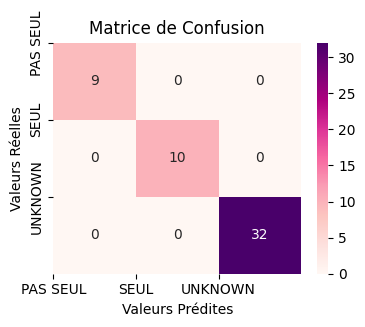

In [448]:
# Matrice de confusion
cm = confusion_matrix(df_final['situation_V'], df_final['situation'])

# Création d'une figure avec Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='RdPu', fmt='g')

# Définition des labels et du titre
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')

# Définition des étiquettes des axes x et y avec un alignement au centre
tick_labels = ['PAS SEUL', 'SEUL', 'UNKNOWN']
plt.xticks(ticks=range(len(tick_labels)), labels=tick_labels)
plt.yticks(ticks=range(len(tick_labels)), labels=tick_labels)

# Affichage de la figure
plt.show()

In [451]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

y_true = df_final['situation_V'].values
y_pred = df_final['situation'].values

In [452]:
# Calculez les métriques
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred)

# Affichez les résultats

print("Précision globale (Accuracy):", round(accuracy,2))
print("Classification Report:")
print(report)

Précision globale (Accuracy): 1.0
Classification Report:
              precision    recall  f1-score   support

    PAS SEUL       1.00      1.00      1.00         9
        SEUL       1.00      1.00      1.00        10
     UNKNOWN       1.00      1.00      1.00        32

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51

